# iStar Benchmark (INT25-INT28)

## 环境配置说明
iStar 依赖于特定的 PyTorch 版本和库。建议创建一个新的 Conda 环境。

### 1. 创建并激活新环境
```bash
conda create -n istar_bench python=3.9
conda activate istar_bench
```

### 2. 安装依赖
```bash
# 安装 PyTorch 2.0.1 (根据 CUDA 版本调整，这里示例为 CUDA 11.8)
pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118

# 安装其他依赖
pip install numpy==1.25.2 pillow==10.0.0 pandas==2.1.0 scikit-image==0.21.0 opencv-python==4.8.0.76 einops==0.6.1 tomli==2.0.1 pytorch-lightning==2.0.8 matplotlib==3.7.2 scikit-learn==1.3.1 umap-learn==0.5.5 seaborn==0.13.1 scanpy scprep tqdm openslide-python
```

**注意**：同样需要安装 OpenSlide 二进制文件并配置 PATH。

---

## 任务描述
对比 Morpho-VC 与 iStar 在 INT25-INT28 数据集上的表现。

**流程**：
1. **数据准备**：将 HEST 数据转换为 iStar 格式（图像 + 表达矩阵 + 坐标）。
2. **预处理**：运行 iStar 的预处理和特征提取脚本。
3. **训练**：在 INT25 上训练，保存模型；接着在 INT26 上微调（模拟多切片训练）。
4. **预测**：在 INT28 上预测。
5. **评估**：计算 MAE, RMSE, Pearson。

In [1]:
import os
import sys
import json
import shutil
import subprocess
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import scanpy as sc
from PIL import Image
from tqdm import tqdm

# OpenSlide Fix for Windows
if os.name == 'nt':
    conda_prefix = os.environ.get('CONDA_PREFIX')
    curr_python = sys.executable
    possible_paths = []
    if conda_prefix:
        possible_paths.append(Path(conda_prefix) / 'Library' / 'bin')
    if curr_python:
        possible_paths.append(Path(curr_python).parent / 'Library' / 'bin')
        possible_paths.append(Path(curr_python).parent / '..' / 'Library' / 'bin')
    for p in possible_paths:
        if p.exists() and ((p / 'libopenslide-1.dll').exists() or (p / 'libopenslide-0.dll').exists()):
            print(f"Found OpenSlide DLL at: {p}")
            try:
                os.add_dll_directory(str(p))
            except AttributeError:
                pass
            os.environ['PATH'] = str(p) + os.pathsep + os.environ['PATH']
            break

try:
    import openslide
except ImportError:
    print("OpenSlide not found. ROI extraction might fail if not using PIL fallback correctly.")

# 路径设置
ROOT = Path(os.environ.get('MORPHO_VC_ROOT', '../')).expanduser().resolve()
print(f"ROOT: {ROOT}")

sys.path.append(str(ROOT / 'src'))
sys.path.append(str(ROOT / 'benchmark'))

from hest_dataset import HESTHisToGeneDataset
 
# iStar 源码路径
ISTAR_ROOT = ROOT / 'benchmark' / 'istar'
sys.path.append(str(ISTAR_ROOT))

# 结果与临时数据目录
RESULT_DIR = ROOT / 'benchmark' / 'results' / 'istar'
DATA_ROOT = RESULT_DIR / 'data' # iStar 脚本通常在 data/ 目录下找数据
RESULT_DIR.mkdir(parents=True, exist_ok=True)
DATA_ROOT.mkdir(parents=True, exist_ok=True)

# 数据路径
spatial_dir = ROOT / 'data' / 'spatial_data'
hest_dir = ROOT / 'data' / 'hest_data'
common_gene_path = spatial_dir / 'common_genes.txt'

with open(common_gene_path, 'r') as f:
    common_genes = f.read().splitlines()

print(f"Common Genes: {len(common_genes)}")

ROOT: D:\code\Morpho-VC
Common Genes: 17512


In [2]:
# Check and download iStar checkpoints
import urllib.request

# Override SSL context to avoid errors in some envs
import ssl
try:
    ssl._create_default_https_context = ssl._create_unverified_context
except AttributeError:
    pass

CHECKPOINT_DIR = ISTAR_ROOT / 'checkpoints'
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

urls = {
    "vit256_small_dino.pth": "https://github.com/mahmoodlab/HIPT/raw/master/HIPT_4K/Checkpoints/vit256_small_dino.pth",
    "vit4k_xs_dino.pth": "https://github.com/mahmoodlab/HIPT/raw/master/HIPT_4K/Checkpoints/vit4k_xs_dino.pth"
}

headers = {'User-Agent': 'Mozilla/5.0'}

for name, url in urls.items():
    target_path = CHECKPOINT_DIR / name
    if not target_path.exists():
        print(f"Downloading {name}...")
        try:
            req = urllib.request.Request(url, headers=headers)
            with urllib.request.urlopen(req) as response, open(target_path, 'wb') as out_file:
                out_file.write(response.read())
            print("Done.")
        except Exception as e:
            print(f"Failed to download {name}: {e}")
    else:
        print(f"{name} exists.")

vit256_small_dino.pth exists.
vit4k_xs_dino.pth exists.


## 1. 数据转换 (HEST -> iStar)

iStar 需要每个样本一个文件夹，包含：
- `he-raw.jpg`: 高分辨率 H&E 图像
- `cnts.tsv`: 基因计数矩阵 (Spots x Genes)
- `locs-raw.tsv`: Spot 坐标 (image pixel coordinates)
- `pixel-size-raw.txt`: 像素大小 (um)
- `radius-raw.txt`: Spot 半径 (pixels)

我们将使用 `HESTHisToGeneDataset` 中的逻辑来加载数据，然后保存为上述格式。

In [3]:
def convert_hest_to_istar(slide_id, output_dir):
    print(f"Processing {slide_id}...")
    sample_dir = output_dir / slide_id
    
    # Check if exists (robust check)
    if sample_dir.exists() and (sample_dir / 'cnts.tsv').exists():
        # Check for gene-names.txt
        if not (sample_dir / 'gene-names.txt').exists():
             print("  Injecting missing gene-names.txt...")
             # Load header to get genes
             df_head = pd.read_csv(sample_dir / 'cnts.tsv', sep='\t', index_col=0, nrows=0)
             genes = df_head.columns.tolist()
             with open(sample_dir / 'gene-names.txt', 'w') as f:
                 for g in genes:
                     f.write(g + '\n')
        
        # Check for pixel-size.txt
        if not (sample_dir / 'pixel-size.txt').exists():
            print("  Injecting missing pixel-size.txt...")
            with open(sample_dir / 'pixel-size.txt', 'w') as f:
                f.write('0.5')
                
        print(f"  {sample_dir} valid. Skipping conversion.")
        return
        
    sample_dir.mkdir(parents=True, exist_ok=True)
    
    # 1. Load h5ad
    adata_path = spatial_dir / f"{slide_id}.h5ad"
    adata = sc.read_h5ad(adata_path)
    
    # Filter Common Genes
    adata = adata[:, common_genes].copy()
    
    # 2. Save counts (cnts.tsv)
    # Row 1: Gene names
    # Col 1: Spot ID
    df_cnts = pd.DataFrame(adata.X.toarray() if scipy.sparse.issparse(adata.X) else adata.X, 
                           index=adata.obs_names, columns=adata.var_names)
    df_cnts.index.name = 'SpotID'
    df_cnts.reset_index(inplace=True)
    df_cnts.to_csv(sample_dir / 'cnts.tsv', sep='\t', index=False)
    
    # Save gene-names.txt (Required by iStar impute.py)
    with open(sample_dir / 'gene-names.txt', 'w') as f:
        for g in adata.var_names:
            f.write(g + '\n')
    
    # 3. Process Image & Coordinates
    # Read WSI path
    tiff_path = hest_dir / 'wsis' / f"{slide_id}.tif"
    if not tiff_path.exists():
        tiff_path = hest_dir / 'wsis' / f"{slide_id}.svs"
    
    if not tiff_path.exists():
        raise FileNotFoundError(f"WSI not found for {slide_id}")
        
    slide = openslide.OpenSlide(str(tiff_path))
    w, h = slide.dimensions
    
    # Target Max Size
    MAX_SIZE = 4000
    scale = min(MAX_SIZE / w, MAX_SIZE / h)
    
    # Calculate level
    level = slide.get_best_level_for_downsample(1/scale)
    img = slide.read_region((0, 0), level, slide.level_dimensions[level])
    img = img.convert('RGB')
    
    # True scale
    true_scale_w = img.size[0] / w
    true_scale_h = img.size[1] / h
    
    # Save Image
    img.save(sample_dir / 'he-raw.jpg')
    
    # 4. Save Coordinates (locs-raw.tsv)
    coords = adata.obsm['spatial'].copy().astype(float)
    coords[:, 0] *= true_scale_w
    coords[:, 1] *= true_scale_h
    
    df_locs = pd.DataFrame(coords, index=adata.obs_names, columns=['x', 'y'])
    df_locs.index.name = 'SpotID'
    df_locs.reset_index(inplace=True)
    df_locs.to_csv(sample_dir / 'locs-raw.tsv', sep='\t', index=False)
    
    # 5. Pixel Size & Radius
    # HEST slides usually ~0.5 um/px.
    original_mpp = 0.5 
    current_pixel_size = original_mpp / true_scale_w
    
    with open(sample_dir / 'pixel-size-raw.txt', 'w') as f:
        f.write(str(current_pixel_size))
        
    # Radius ~50um
    radius_px = 50.0 / current_pixel_size
    with open(sample_dir / 'radius-raw.txt', 'w') as f:
        f.write(str(radius_px))
        
    # Create pixel-size.txt for rescale.py
    with open(sample_dir / 'pixel-size.txt', 'w') as f:
        f.write('0.5')
        
    print(f"  Saved to {sample_dir}")
    print(f"  Image Size: {img.size}, Scale: {true_scale_w:.4f}, Pixel Size: {current_pixel_size:.2f}, Radius: {radius_px:.2f}")

import scipy.sparse

# Convert all slides
ids = ['INT25', 'INT26', 'INT27', 'INT28']
for s_id in ids:
    convert_hest_to_istar(s_id, DATA_ROOT)

Processing INT25...
  D:\code\Morpho-VC\benchmark\results\istar\data\INT25 valid. Skipping conversion.
Processing INT26...
  D:\code\Morpho-VC\benchmark\results\istar\data\INT26 valid. Skipping conversion.
Processing INT27...
  D:\code\Morpho-VC\benchmark\results\istar\data\INT27 valid. Skipping conversion.
Processing INT28...
  D:\code\Morpho-VC\benchmark\results\istar\data\INT28 valid. Skipping conversion.


## 2. 运行 iStar 预处理

对每个样本运行特征提取。这可能需要一些时间。
iStar 脚本路径：`benchmark/istar/*.py`

In [4]:
def run_istar_preprocess(slide_id):
    print(f"Preprocessing {slide_id}...")
    prefix = f"results/istar/data/{slide_id}/"
    # 注意：我们要在 istar 目录下运行命令，以便它能找到其他模块
    # 或者设置 PYTHONPATH。简便起见，我们在 ISTAR_ROOT 下运行，并传递相对路径。
    
    # 相对路径计算
    # ISTAR_ROOT is d:\code\Morpho-VC\benchmark\istar
    # Data is d:\code\Morpho-VC\benchmark\results\istar\data\{slide_id}
    # Relative path from ISTAR_ROOT to Data
    rel_prefix = os.path.relpath(DATA_ROOT / slide_id, ISTAR_ROOT).replace('\\', '/') + '/'
    
    cmds = [
        # 1. Rescale (Scale image to desired pixel size, typically 0.5um)
        # 我们在转换时已经计算了 pixel-size-raw.txt
        f"python rescale.py {rel_prefix} --image",
        
        # 2. Preprocess (Tiling, etc.)
        f"python preprocess.py {rel_prefix} --image",
        
        # 3. Extract Features (CNN + ViT features)
        f"python extract_features.py {rel_prefix} --device=cuda",
        
        # 4. Get Mask
        f"python get_mask.py {rel_prefix}embeddings-hist.pickle {rel_prefix}mask-small.png",
        
        # 5. Rescale locs & radius for prediction map
        f"python rescale.py {rel_prefix} --locs --radius"
    ]
    
    for cmd in cmds:
        print(f"Running: {cmd}")
        ret = subprocess.run(cmd, shell=True, cwd=str(ISTAR_ROOT), capture_output=True, text=True)
        if ret.returncode != 0:
            print(f"Error running {cmd}")
            print("STDOUT:", ret.stdout)
            print("STDERR:", ret.stderr)
            # raise RuntimeError(f"Failed: {cmd}")

# 预处理所有数据
for s_id in ids:
    if not (DATA_ROOT / s_id / 'embeddings-hist.pickle').exists():
        run_istar_preprocess(s_id)
    else:
        print(f"{s_id} already preprocessed.")

INT25 already preprocessed.
INT26 already preprocessed.
INT27 already preprocessed.
INT28 already preprocessed.


## 3. 模型训练 (序列化)

iStar 默认是对单张切片进行 Imputation (Training & Inference)。
为了利用多张切片的信息，我们采用序列训练策略：
1. 在 INT25 上训练，保存 Checkpoint。
2. 加载 INT25 Checkpoint，在 INT26 上继续训练 (Fine-tune)。
3. 最终模型用于 INT28 预测。

我们调用 `impute.py`，但需要稍作修改以支持 `load_saved` (iStar 原版支持 --load-saved 参数)。

In [5]:
def train_istar_seq(train_ids, epochs=400):
    # 1. Train on first slide
    first_id = train_ids[0]
    print(f"Training on {first_id}...")
    rel_prefix_1 = os.path.relpath(DATA_ROOT / first_id, ISTAR_ROOT).replace('\\', '/') + '/'

    # Clean previous states if any
    # shutil.rmtree(DATA_ROOT / first_id / 'states', ignore_errors=True)

    # Use sys.executable to ensure compatible environment
    # ADDED: encoding='utf-8', errors='replace' to fix UnicodeDecodeError on Windows
    cmd1 = f"\"{sys.executable}\" impute.py {rel_prefix_1} --epochs={epochs} --device=cuda"
    print(f"Running: {cmd1}")
    ret1 = subprocess.run(cmd1, shell=True, cwd=str(ISTAR_ROOT), capture_output=True, text=True, encoding='utf-8', errors='replace')
    if ret1.returncode != 0:
        print(f"Error running training on {first_id}")
        print("STDOUT:", ret1.stdout)
        print("STDERR:", ret1.stderr)
        raise RuntimeError("Training failed")

    # 2. Train on subsequent slides
    prev_id = first_id
    for next_id in train_ids[1:]:
        print(f"Fine-tuning on {next_id} initialized from {prev_id}...")
        rel_prefix_next = os.path.relpath(DATA_ROOT / next_id, ISTAR_ROOT).replace('\\', '/') + '/'

        # Copy states from prev to next
        src_states = DATA_ROOT / prev_id / 'states'
        dst_states = DATA_ROOT / next_id / 'states'
        if dst_states.exists():
            shutil.rmtree(dst_states)
        shutil.copytree(src_states, dst_states)

        # Resume/Finetune
        # iStar impute.py --load-saved flag loads from {prefix}states/
        cmd2 = f"\"{sys.executable}\" impute.py {rel_prefix_next} --epochs={epochs} --device=cuda --load-saved"
        print(f"Running: {cmd2}")
        ret2 = subprocess.run(cmd2, shell=True, cwd=str(ISTAR_ROOT), capture_output=True, text=True, encoding='utf-8', errors='replace')
        if ret2.returncode != 0:
            print(f"Error running fine-tuning on {next_id}")
            print("STDOUT:", ret2.stdout)
            print("STDERR:", ret2.stderr)
            raise RuntimeError("Fine-tuning failed")

        prev_id = next_id

    return prev_id # Last trained slide ID
# 训练
if not (DATA_ROOT / 'INT26' / 'states').exists():
    last_trained_id = train_istar_seq(['INT25', 'INT26'], epochs=200)
else:
    print("Training seems done. Using INT26 states.")
    last_trained_id = 'INT26'

Training seems done. Using INT26 states.


## 4. 预测 (INT28)

我们将训练好的模型（存在 `INT26/states` 中）复制到 `INT28/states`，然后以 `load-saved` 模式运行 `impute.py` 但 **0 epochs** (或者极少 epochs，只做预测)。
实际上，`impute.py` 会在训练后进行预测并保存结果。
为了只做预测，我们可以修改 `impute.py` 或者使用 trick：set epochs=0。
如果 `epochs=0` 不工作，我们设置 `epochs=1` 但学习率极低？
查看 `impute.py`：`train_load_model` 会执行 `trainer.fit`。如果 epochs=0，Lightning 应该会跳过训练。
然后它调用 `predict` 函数生成 `cnts-super`。

In [6]:
def predict_istar(model_source_id, target_id):
    print(f"Predicting on {target_id} using model from {model_source_id}...")
    rel_prefix_tgt = os.path.relpath(DATA_ROOT / target_id, ISTAR_ROOT).replace('\\', '/') + '/'
    
    # Copy states
    src_states = DATA_ROOT / model_source_id / 'states'
    dst_states = DATA_ROOT / target_id / 'states'
    if dst_states.exists():
        shutil.rmtree(dst_states)
    shutil.copytree(src_states, dst_states)
    
    # Run with epochs=0 to skip training and just predict
    cmd = f"\"{sys.executable}\" impute.py {rel_prefix_tgt} --epochs=0 --device=cuda --load-saved"
    print(f"Running: {cmd}")
    ret = subprocess.run(cmd, shell=True, cwd=str(ISTAR_ROOT), capture_output=True, text=True)
    if ret.returncode != 0:
        print(f"Error running prediction on {target_id}")
        print("STDOUT:", ret.stdout)
        print("STDERR:", ret.stderr)
        raise RuntimeError("Prediction failed")

predict_istar(last_trained_id, 'INT28')

Predicting on INT28 using model from INT26...
Running: "c:\ProgramData\anaconda3\envs\istar_bench\python.exe" impute.py ../results/istar/data/INT28/ --epochs=0 --device=cuda --load-saved


## 5. 评估

1. 读取 `INT28` 的真实值 (`cnts.tsv`)。
2. 读取 `INT28` 的预测值 (`cnts-super/*.pickle`)。
3. 计算 Metrics。

In [13]:
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm

def load_istar_predictions(slide_id):
    pred_dir = DATA_ROOT / slide_id / 'cnts-super'

    # 1. Load Real Counts & Coordinates
    # We need locs.tsv to map spots to the prediction grid
    print(f"Loading metadata for {slide_id}...")
    true_df = pd.read_csv(DATA_ROOT / slide_id / 'cnts.tsv', sep='\t')
    locs_df = pd.read_csv(DATA_ROOT / slide_id / 'locs.tsv', sep='\t')

    # Ensure alignment
    true_df = true_df.set_index('SpotID')
    locs_df = locs_df.set_index('SpotID')
    locs_df = locs_df.loc[true_df.index]

    # Get coordinates (x=col, y=row)
    xs = locs_df['x'].values
    ys = locs_df['y'].values

    # Calculate grid indices (Factor = 16)
    scale_factor = 16
    grid_rows = (ys / scale_factor).astype(int)
    grid_cols = (xs / scale_factor).astype(int)

    genes = true_df.columns
    pred_matrix = np.zeros_like(true_df.values, dtype=np.float32)

    print(f"Loading predictions for {len(genes)} genes...")
    missing = 0
    max_h, max_w = 0, 0

    for i, gene in enumerate(tqdm(genes)):
        p_path = pred_dir / f"{gene}.pickle"
        if p_path.exists():
            with open(p_path, 'rb') as f:
                val = pickle.load(f) # Shape: (864, 912)

            if max_h == 0:
                max_h, max_w = val.shape
                # Clip indices just in case coordinates are slightly out of bound
                grid_rows = np.clip(grid_rows, 0, max_h - 1)
                grid_cols = np.clip(grid_cols, 0, max_w - 1)

            # Sample from grid: val[row, col]
            pred_matrix[:, i] = val[grid_rows, grid_cols]
        else:
            missing += 1

    print(f"Loaded {len(genes)} genes. Missing: {missing}")
    return pred_matrix, true_df.values, genes

pred_bag, true_bag, genes = load_istar_predictions('INT28')

# Metrics
mae = np.mean(np.abs(pred_bag - true_bag))
rmse = np.sqrt(np.mean((pred_bag - true_bag) ** 2))

def pearson_corr(a, b):
    if np.all(a == a[0]) or np.all(b == b[0]):
        return np.nan
    a = a - a.mean()
    b = b - b.mean()
    denom = np.sqrt((a * a).sum()) * np.sqrt((b * b).sum())
    if denom == 0:
        return np.nan
    return float((a * b).sum() / denom)

gene_corrs = []
for i in range(pred_bag.shape[1]):
    corr = pearson_corr(pred_bag[:, i], true_bag[:, i])
    gene_corrs.append(corr)

valid = [(i, c) for i, c in enumerate(gene_corrs) if not np.isnan(c)]
mean_gene_corr = float(np.mean([c for _, c in valid])) if valid else float('nan')

best_idx, best_corr = max(valid, key=lambda x: x[1]) if valid else (None, None)
best_gene = genes[best_idx] if best_idx is not None else "NA"

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'Mean Pearson: {mean_gene_corr:.4f}')
print(f'Best Gene: {best_gene} ({best_corr:.4f})')

metrics = {
    'MAE': float(mae),
    'RMSE': float(rmse),
    'Mean_Pearson': float(mean_gene_corr) if not pd.isna(mean_gene_corr) else None,
    'Best_Gene': best_gene,
    'Best_Pearson': float(best_corr) if best_corr is not None else None
}

with open(RESULT_DIR / 'metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)

Loading metadata for INT28...
Loading predictions for 17512 genes...


100%|██████████| 17512/17512 [00:51<00:00, 341.42it/s]


Loaded 17512 genes. Missing: 0
MAE: 0.9464
RMSE: 5.9053
Mean Pearson: 0.1846
Best Gene: KLK3 (0.5695)


Loading spatial data from: D:\code\Morpho-VC\data\spatial_data\INT28.h5ad
Coords Range: X[2884.0, 12363.0], Y[1596.0, 11424.0]
Found WSI: D:\code\Morpho-VC\data\hest_data\wsis\INT28.tif
WSI dims (original): 14528 x 13580
Using pixel-space extent (0..W, H..0) for alignment.


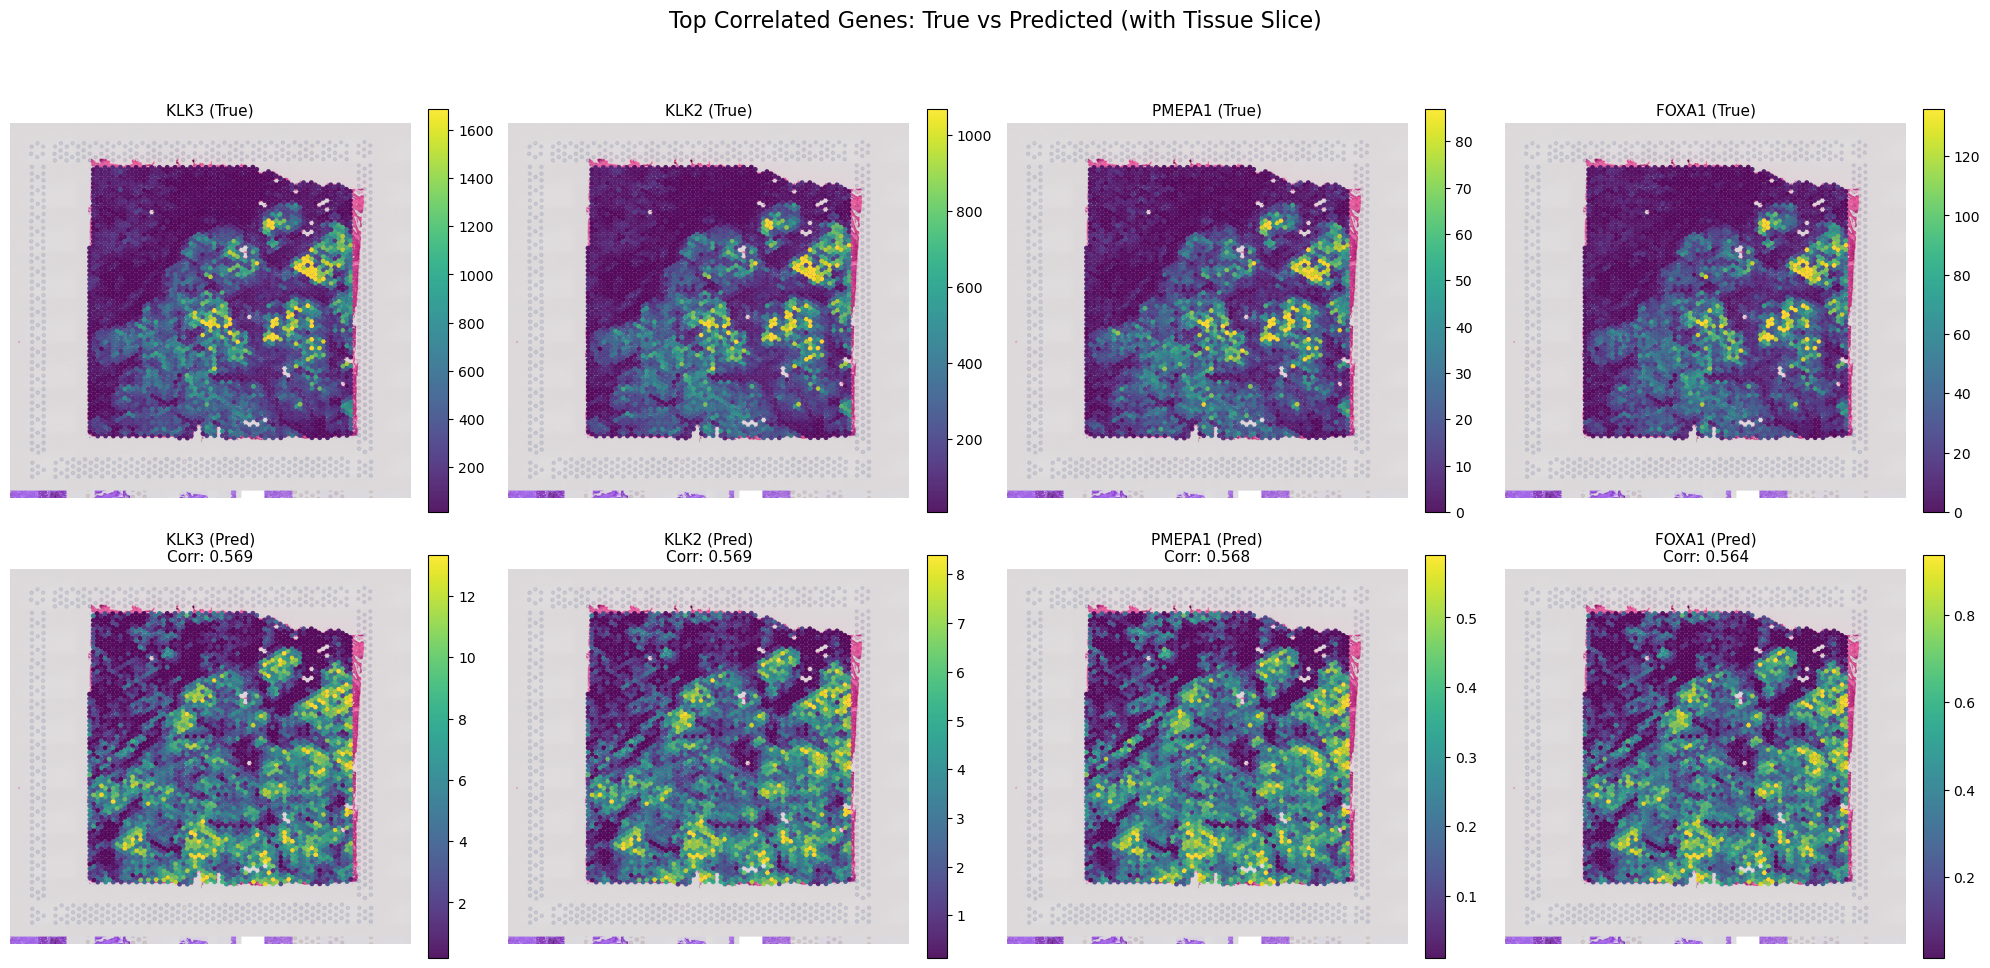

In [15]:
# === Visualizing Spatial Gene-Expression (Top-4) WITH Tissue Slice Background ===
import os
from pathlib import Path

import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

# Optional: background loading
try:
    from PIL import Image
except ImportError:
    Image = None


def robust_vmin_vmax(arr, p_low=1, p_high=99):
    """
    Compute (vmin, vmax) from *this panel's* values only (robust percentiles).
    Each panel (each subplot) can have its own scale.
    """
    a = np.asarray(arr, dtype=float)
    a = a[np.isfinite(a)]
    if a.size == 0:
        return 0.0, 1.0

    vmin, vmax = np.percentile(a, [p_low, p_high])
    if (not np.isfinite(vmin)) or (not np.isfinite(vmax)) or (vmin == vmax):
        vmin, vmax = float(np.min(a)), float(np.max(a))
        if vmin == vmax:
            eps = 1e-6 if vmin == 0 else abs(vmin) * 1e-6
            vmin, vmax = vmin - eps, vmax + eps
    return vmin, vmax


# ----------------------------
# 0) Paths & IDs
# ----------------------------
TEST_ID = "INT28"

ROOT = Path(os.environ.get("MORPHO_VC_ROOT", "../")).expanduser().resolve()
DATA_DIR = ROOT / "data" / "spatial_data"
HEST_DIR = ROOT / "data" / "hest_data"

h5ad_path = DATA_DIR / f"{TEST_ID}.h5ad"
if not h5ad_path.exists():
    # fallback
    h5ad_path = Path(f"../../data/spatial_data/{TEST_ID}.h5ad").resolve()

print(f"Loading spatial data from: {h5ad_path}")

# ----------------------------
# 1) Load spatial coords
# ----------------------------
try:
    adata = sc.read_h5ad(h5ad_path)
    coords = adata.obsm["spatial"]  # shape (N, 2)
    x, y = coords[:, 0], coords[:, 1]

    min_x, min_y = coords.min(axis=0)
    max_x, max_y = coords.max(axis=0)
    print(f"Coords Range: X[{min_x:.1f}, {max_x:.1f}], Y[{min_y:.1f}, {max_y:.1f}]")
except Exception as e:
    print(f"[ERROR] Failed to load spatial coords: {e}")
    # Last resort fallback
    # Attempt to use 'pred_bag' or 'pred' shape
    try:
        n_points = pred_bag.shape[0]
    except NameError:
        try:
            n_points = pred.shape[0]
        except NameError:
            n_points = 100  # Dummy

    x, y = np.random.rand(n_points), np.random.rand(n_points)
    min_x, min_y, max_x, max_y = x.min(), y.min(), x.max(), y.max()

# ----------------------------
# 2) Try load WSI background (tissue slice)
# ----------------------------
bg_img = None
bg_extent = None

try:
    wsi_files = list((HEST_DIR / "wsis").glob(f"{TEST_ID}.*"))
    if len(wsi_files) > 0:
        wsi_path = wsi_files[0]
        print(f"Found WSI: {wsi_path}")

        # Try OpenSlide first
        try:
            import openslide

            slide = openslide.OpenSlide(str(wsi_path))
            w0, h0 = slide.dimensions
            print(f"WSI dims (original): {w0} x {h0}")

            thumb_w = 2000
            scale = thumb_w / w0
            thumb_h = int(h0 * scale)
            bg_img = slide.get_thumbnail((thumb_w, thumb_h))

            in_pixel_space = (
                (min_x >= -0.05 * w0) and (max_x <= 1.05 * w0) and
                (min_y >= -0.05 * h0) and (max_y <= 1.05 * h0)
            )

            if in_pixel_space:
                bg_extent = (0, w0, h0, 0)
                print("Using pixel-space extent (0..W, H..0) for alignment.")
            else:
                bg_extent = (min_x, max_x, max_y, min_y)
                print("Coords not in pixel space; stretching background to coords bounding box.")

        except Exception as e:
            print(f"OpenSlide failed ({e}), trying PIL...")
            if Image:
                Image.MAX_IMAGE_PIXELS = None
                img = Image.open(wsi_path)
                w0, h0 = img.size
                print(f"WSI dims (PIL original): {w0} x {h0}")

                img.thumbnail((2000, 2000))
                bg_img = img

                in_pixel_space = (
                    (min_x >= -0.05 * w0) and (max_x <= 1.05 * w0) and
                    (min_y >= -0.05 * h0) and (max_y <= 1.05 * h0)
                )
                if in_pixel_space:
                    bg_extent = (0, w0, h0, 0)
                    print("Using pixel-space extent (0..W, H..0) for alignment.")
                else:
                    bg_extent = (min_x, max_x, max_y, min_y)
                    print("Coords not in pixel space; stretching background to coords bounding box.")
            else:
                print("PIL not available.")
    else:
        print("[INFO] No WSI found under:", (HEST_DIR / "wsis"))
except Exception as e:
    print(f"[WARNING] Background loading failed: {e}")

# ----------------------------
# 3) Pick Top-4 genes by correlation
# ----------------------------
try:
    # valid is list of (idx, corr)
    sorted_genes = sorted(valid, key=lambda t: t[1], reverse=True)
    top4_genes = sorted_genes[:4]
    n_show = len(top4_genes)
    if n_show == 0:
        print("No valid genes found.")
except NameError:
    print("Variable 'valid' not defined. Cannot select top genes.")
    top4_genes = []
    n_show = 0

# ----------------------------
# 4) Plot (2 rows: True vs Pred)
# ----------------------------
if n_show > 0:
    fig, axes = plt.subplots(2, n_show, figsize=(5 * n_show, 10))
    if n_show == 1:
        axes = np.array(axes).reshape(2, 1)

    fig.suptitle("Top Correlated Genes: True vs Predicted (with Tissue Slice)", fontsize=16, y=0.98)

    for i, (gene_idx, corr) in enumerate(top4_genes):
        gene_name = common_genes[gene_idx]

        # Handle variable names (pred_bag/true_bag vs pred/true)
        try:
            gt_expr = true_bag[:, gene_idx]
            pr_expr = pred_bag[:, gene_idx]
        except NameError:
            gt_expr = true[:, gene_idx]
            pr_expr = pred[:, gene_idx]

        # ✅ IMPORTANT: panel-wise scaling (each subplot has its own vmin/vmax)
        vmin_gt, vmax_gt = robust_vmin_vmax(gt_expr, p_low=1, p_high=99)
        vmin_pr, vmax_pr = robust_vmin_vmax(pr_expr, p_low=1, p_high=99)

        # --- Row 1: Ground Truth ---
        ax_gt = axes[0, i]
        if bg_img is not None and bg_extent is not None:
            ax_gt.imshow(bg_img, extent=bg_extent)
        sc_gt = ax_gt.scatter(
            x, y, c=gt_expr, cmap="viridis", s=12, alpha=0.9,
            vmin=vmin_gt, vmax=vmax_gt, edgecolors="none"
        )
        ax_gt.set_title(f"{gene_name} (True)", fontsize=11)
        ax_gt.axis("off")
        if bg_img is None:
            ax_gt.invert_yaxis()
        plt.colorbar(sc_gt, ax=ax_gt, fraction=0.046, pad=0.04)

        # --- Row 2: Prediction ---
        ax_pr = axes[1, i]
        if bg_img is not None and bg_extent is not None:
            ax_pr.imshow(bg_img, extent=bg_extent)
        sc_pr = ax_pr.scatter(
            x, y, c=pr_expr, cmap="viridis", s=12, alpha=0.9,
            vmin=vmin_pr, vmax=vmax_pr, edgecolors="none"
        )
        ax_pr.set_title(f"{gene_name} (Pred)\nCorr: {corr:.3f}", fontsize=11)
        ax_pr.axis("off")
        if bg_img is None:
            ax_pr.invert_yaxis()
        plt.colorbar(sc_pr, ax=ax_pr, fraction=0.046, pad=0.04)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
